# Intro to Natural Language Processing (NLP)

The Natural Language Processing (NLP) field is incredibly vast, and it has applications in virtually every aspect of data science. In this notebook, we will walk through a **very brief** survey of NLP, and provide some instruction on a couple handy tools along the way.

*Note: NLP tools span a wide range of implementations, and it is not uncommon for NLP packages to have conflicts with other Python libraries. So, to keep everything compatible in one place, it is recommended that you keep a separate pip environment for NLP projects.*

## Preprocessing

To illustrate preprocessing text data, we'll use the [spaCy](https://spacy.io/) package. To use the spaCy library, you first need to install a [spaCy model](https://spacy.io/models).

In [1]:
# THIS CELL ONLY NEEDS TO BE RUN ONCE
# !python -m spacy download en_core_web_sm

Second, until [this issue](https://github.com/explosion/spaCy/pull/13787) is merged (check first), there is a bit of a version incompatibility between spaCy and IPython that interferes with our ability to use one of the spaCy tools below. So, until the issue is resolved, you'll need to install an older version of IPython and **then restart your kernel**.

In [ ]:
# THIS CELL ONLY NEEDS TO BE RUN ONCE (RESTART KERNEL AFTER RUNNING)
# !pip install -U "ipython<9"

Now we can import packages as usual.

In [3]:
import pandas as pd
import spacy
from spacy import displacy

print(spacy.__version__)

3.8.7


*Note: spaCy is capable of **much** more than what we will use it for in this lab. More advanced implementations of spaCy may require knowledge outside the scope of this course.*

### Tokenizing

The very first part of dealing with text data is to collect each **term** or unitary element of text (e.g., words, punctuation, etc.) in the form of "tokens".

In [4]:
# depends on your choice of spaCy model
nlp = spacy.load('en_core_web_sm')

In [5]:
intro = '''The Natural Language Processing (NLP) field is incredibly vast,
and it has applications in virtually every aspect of data science.
In this notebook, we will walk through a **very brief** survey of NLP,
and provide some instruction on a couple handy tools along the way.
'''

doc = nlp(intro)

In [6]:
print([t.text for t in doc])

['The', 'Natural', 'Language', 'Processing', '(', 'NLP', ')', 'field', 'is', 'incredibly', 'vast', ',', '\n', 'and', 'it', 'has', 'applications', 'in', 'virtually', 'every', 'aspect', 'of', 'data', 'science', '.', '\n', 'In', 'this', 'notebook', ',', 'we', 'will', 'walk', 'through', 'a', '*', '*', 'very', 'brief', '*', '*', 'survey', 'of', 'NLP', ',', '\n', 'and', 'provide', 'some', 'instruction', 'on', 'a', 'couple', 'handy', 'tools', 'along', 'the', 'way', '.', '\n']


In [7]:
for i, sentence in enumerate(doc.sents):
    print(f"sentence {i+1}\n\n", sentence)

sentence 1

 The Natural Language Processing (NLP) field is incredibly vast,
and it has applications in virtually every aspect of data science.

sentence 2

 In this notebook, we will walk through a **very brief** survey of NLP,
and provide some instruction on a couple handy tools along the way.



In [8]:
df_intro = []

for token in doc:
    df_intro.append([
        token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
        token.shape_, token.is_alpha, token.is_stop
    ])

In [9]:
df_intro = pd.DataFrame(columns=["text", "lemma_", "pos_", "tag_", "dep_", "shape_", "is_alpha", "is_stop"],
                        data=df_intro)

In [10]:
df_intro.sample(5)

,text,lemma_,pos_,tag_,dep_,shape_,is_alpha,is_stop
2,Language,Language,PROPN,NNP,nmod,Xxxxx,True,False
24,.,.,PUNCT,.,punct,.,False,False
5,NLP,NLP,PROPN,NNP,nmod,XXX,True,False
22,data,datum,NOUN,NNS,compound,xxxx,True,False
37,very,very,ADV,RB,advmod,xxxx,True,True


What is a **stop word**?

In [11]:
df_intro[df_intro['is_stop']].sample(10)

,text,lemma_,pos_,tag_,dep_,shape_,is_alpha,is_stop
14,it,it,PRON,PRP,nsubj,xx,True,True
30,we,we,PRON,PRP,nsubj,xx,True,True
34,a,a,DET,DT,det,x,True,True
13,and,and,CCONJ,CC,cc,xxx,True,True
55,along,along,ADP,IN,prep,xxxx,True,True
8,is,be,AUX,VBZ,ROOT,xx,True,True
37,very,very,ADV,RB,advmod,xxxx,True,True
31,will,will,AUX,MD,aux,xxxx,True,True
15,has,have,VERB,VBZ,conj,xxx,True,True
0,The,the,DET,DT,det,Xxx,True,True


spaCy defines **lemmas** to be *"the base forms of words. For example, the lemma of `was` is `be`, and the lemma of `rats` is `rat`."*

In [12]:
t = nlp('running')[0]
t.lemma_

'run'

**Sentence Dependencies**

We can visualize some of these attributes (like the sentence dependencies) using [displacy](https://spacy.io/usage/visualizers). 

*Note: until [this](https://github.com/explosion/spaCy/pull/13787) issue is merged (check first), there is a bit of a version issue between spaCy and IPython that interferes with our ability to use one of the spaCy tools below. Try to run 

In [13]:
doc = nlp('We can visualize these using displacy.')

In [14]:
displacy.render(doc, style='dep', options={'distance': 120})

Note: this isn't always going to be *exactly* accurate, but it's very good and still useful.

### Named Entity Recognition

Some words are **Named Entities**: locations like "Alaska", dates like "January 1st", companies like "Google", etc. spaCy can tag these using [Named Entity Recognition](https://spacy.io/usage/linguistic-features#named-entities).

In [16]:
doc = nlp('... locations like "Alaska", dates like "January 1st", companies like "Google", etc.')

In [17]:
displacy.render(doc, style='ent')

### Multiple Documents

*NLP Terms: A **document** is a collection of **tokens**, and a **corpus** is a collection of documents.*

When spaCy processes text, it runs it through a [pipeline](https://spacy.io/usage/processing-pipelines) of different models to store token attributes for each token. This is how we get the functionality above. Though, when we are tokenizing multiple documents, we might not need all of these [built-in components](https://spacy.io/usage/processing-pipelines#built-in). For example, we might just need enough to filter our text based on the analysis done.

For example, suppose we've determined that we want to the remove the following tokens from a dataset of [coffee reviews](https://www.kaggle.com/datasets/schmoyote/coffee-reviews-dataset/) (descriptions):

- stop words (except the lemma "not", to maintain the idea of object negation)
- punctuation
- numbers

In this case, we don't need NER, Dependency Labels, or Document Labels. Removing these processes from the spaCy pipeline will save us some time.

In [ ]:
df_coffee = pd.read_csv('https://raw.githubusercontent.com/leontoddjohnson/datasets/main/data/coffee_analysis.csv')

In [ ]:
df_coffee.drop_duplicates(subset='desc_1', inplace=True)

In [ ]:
df_coffee.shape

(2092, 12)

In [ ]:
# df_coffee['desc_1']

In [ ]:
print(df_coffee['desc_1'].sample().iloc[0])

Sweet, crisply nut- and cocoa-toned. Cocoa, hazelnut, honey, a hint of lime zest, artichoke blossom in aroma and cup. Delicately crisp, lightly zesty in structure; light and silky in mouthfeel. Surprisingly resonant in the finish, with flavor consolidating around flowers and a hint of citrus.


In [ ]:
# nlp.pipe returns a generator
docs = nlp.pipe(df_coffee['desc_1'], disable=['ner', 'parser', 'textcat'])

# save the spaCy objects into the DataFrame
df_coffee['spacy_doc'] = list(docs)

In [ ]:
def tokenizer(doc, join_tokens=False):
    '''
    Tokenize a single spaCy `doc`.

    join_tokens : bool
        Whether we want to return a single string or
        a list of tokens. If True, join with space (" ").
    '''

    # collect lemmas that meet the following criteria:
    tokens = [w.lemma_.lower() for w in doc if
              (not w.is_stop
               and not w.is_punct
               and not w.like_num) \
              or (w.lemma_ == 'not')]

    if join_tokens:
        return ' '.join(tokens)
    else:
        return tokens

In [ ]:
df_coffee['docs_clean'] = df_coffee['spacy_doc'].apply(tokenizer)

In [ ]:
df_coffee[['desc_1', 'spacy_doc', 'docs_clean']].head()

,desc_1,spacy_doc,docs_clean
0,"Evaluated as espresso. Sweet-toned, deeply ric...","(Evaluated, as, espresso, ., Sweet, -, toned, ...","[evaluate, espresso, sweet, tone, deeply, rich..."
1,"Evaluated as espresso. Sweetly tart, floral-to...","(Evaluated, as, espresso, ., Sweetly, tart, ,,...","[evaluate, espresso, sweetly, tart, floral, to..."
2,"Crisply sweet, cocoa-toned. Lemon blossom, roa...","(Crisply, sweet, ,, cocoa, -, toned, ., Lemon,...","[crisply, sweet, cocoa, tone, lemon, blossom, ..."
3,"Delicate, sweetly spice-toned. Pink peppercorn...","(Delicate, ,, sweetly, spice, -, toned, ., Pin...","[delicate, sweetly, spice, tone, pink, pepperc..."
4,"Deeply sweet, subtly pungent. Honey, pear, tan...","(Deeply, sweet, ,, subtly, pungent, ., Honey, ...","[deeply, sweet, subtly, pungent, honey, pear, ..."


In [ ]:
print(df_coffee['desc_1'].iloc[5])

Delicate, richly and sweetly tart. Dried hibiscus, fine musk, almond, sandalwood, raspberry in aroma and cup. Fruit-toned, deeply sweet structure with gently-expressed acidity; buoyant, satiny-smooth mouthfeel. The crisp, flavor-saturated finish is characterized by sweet-tart fruit and floral tones (raspberry, hibiscus).


In [ ]:
print(df_coffee['docs_clean'].iloc[5])

['delicate', 'richly', 'sweetly', 'tart', 'dry', 'hibiscus', 'fine', 'musk', 'almond', 'sandalwood', 'raspberry', 'aroma', 'cup', 'fruit', 'tone', 'deeply', 'sweet', 'structure', 'gently', 'express', 'acidity', 'buoyant', 'satiny', 'smooth', 'mouthfeel', 'crisp', 'flavor', 'saturate', 'finish', 'characterize', 'sweet', 'tart', 'fruit', 'floral', 'tone', 'raspberry', 'hibiscus']


## Vectorization

Once we have our tokens selected and "cleaned", we need to convert the textual data into numerical data. **In other words, we need to convert each token (or document) into a *vector* representation.** There are many ways to represent textual information in the form of numerical data, but in this class we will cover Count Vectorization and Term-Frequency Inverse Document Frequency Vectorization; we'll call these **vectorizers**.

### Brief Intro to Scikit-Learn

**[Scikit-Learn](https://scikit-learn.org/stable/index.html) is the industry standard data science toolkit**, and its modules are used in almost every aspect of data science. Here, we are going to use its [feature extraction module](https://scikit-learn.org/stable/modules/feature_extraction.html), which is built for extracting numerical features from data such as text or images. We will be using it for vectorization of text data, and in these cases, the scikit-learn process is:

1. Preprocess some data (e.g., from text to tokens)
2. Define a model (e.g., a vectorizer)
3. "Fit" that model to the data using `.fit`
4. Transform the data based on the model's parameters using `.transform`
    - We can also combine these last two steps with `.fit_transform`

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%config InlineBackend.figure_formats = ['svg']

### CountVectorizer

CountVectorizer converts each document into a "Bag of Words". In other words, the document is encoded based on the words it contains, **regardless of the order**. And, each term can be represented based on the documents in which it is contained.

In [ ]:
corpus_raw = ['This coffee is really really tasty.',
              'Tea smells and tastes better than coffee.',
              "I have never smelled coffee that smells so good!"]

In [ ]:
cv = CountVectorizer(ngram_range=(1, 1),  # capture "pairs", or "n-tuples" of adjacent words
                     max_df=1.0,          # exclude terms in > `max_df` (or % of) docs
                     min_df=1,            # exclude terms in < `min_df` (or % of) docs
                     max_features=None,   # maximum number of terms/ngrams to include
                     binary=False)        # only log 1s and 0s for term presence

X = cv.fit_transform(corpus_raw)

df = pd.DataFrame(X.toarray(),
                  index=corpus_raw,
                  columns=cv.get_feature_names_out())

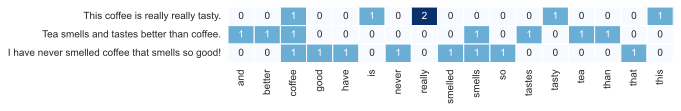

In [ ]:
plt.figure(figsize=(8, 1))
g = sns.heatmap(df, cmap='Blues', annot=True, cbar=False, linewidths=1)

*Note: default behavior is to lowercase all tokens.*

This is called a **document-term matrix**.

- We could use `max_df` to remove the term "coffee" since it occurs in every document. This is one example of extracting *informative* features from text; i.e., the term "coffee" doesn't provide new information for each document.
- Also, we can already see that some of these words give us more information than others. For example, "smelled" and "smells" mean roughly the same thing, and "had"/"have" aren't really necessary for understanding reviews.

This is why we use the filtering in spaCy.

In [ ]:
docs = nlp.pipe(corpus_raw)
corpus_clean = [tokenizer(d, True) for d in docs]
corpus_clean

['coffee tasty', 'tea smell taste well coffee', 'smell coffee smell good']

In [ ]:
cv = CountVectorizer(ngram_range=(1, 1),
                     max_df=0.9,
                     min_df=1,
                     max_features=None,
                     binary=False)

X = cv.fit_transform(corpus_clean)

df = pd.DataFrame(X.toarray(),
                  index=corpus_raw,
                  columns=cv.get_feature_names_out())

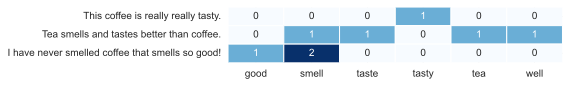

In [ ]:
plt.figure(figsize=(6, 1))
g = sns.heatmap(df, cmap='Blues', annot=True, cbar=False, linewidths=1)

In [ ]:
cv = CountVectorizer(ngram_range=(2, 2),  # use (1, 2) for unigrams *and* bigrams
                     max_df=0.9,
                     min_df=1,
                     max_features=None,
                     binary=False)

X = cv.fit_transform(corpus_clean)

df = pd.DataFrame(X.toarray(),
                  index=corpus_clean,
                  columns=cv.get_feature_names_out())

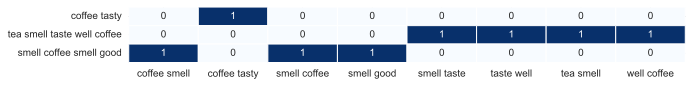

In [ ]:
plt.figure(figsize=(10, 1))
g = sns.heatmap(df, cmap='Blues', annot=True, cbar=False, linewidths=1)

Now these vectors are a bit more meaningful. Notice, in a way, bigrams are a contrived way to capture context in textual data.

### TFIDF Vectorizer

Downsides of Count Vectorizer:

- Counts can be too simplistic
- High counts can dominate, especially for high frequency words or long documents
- Each word is treated equally, when some terms might be more "important" than others

We define TFIDF as:

$$
\text{TF-IDF} = \text{term frequency} * \text{inverse document frequency}
$$

where:

$$
\begin{align*}
\text{term frequency} &= \frac{\text{term count in document}}{\text{total terms in document}} \\[8pt]
\text{inverse document frequency} &= \log\bigg(\frac{\text{total number of documents} + 1}{\text{number of documents with term} + 1}\bigg)
\end{align*}
$$

This measure is calculated for every term-document combination:

- The **term frequency** measures the "density" of a word in a document
- The **inverse document frequency** (without the $\log$) measures the size of the corpus *in terms of* the number of documents containing the term. E.g., if IDF=5 then the corpus is 5 times the size of the "sub-corpus" of documents containing the term. The $\log$ dampens the effect of the inverse document frequency as the denominator gets very small or the numerator gets very large.

So, we can think of TF as the "main" measure, and IDF as the "scaling" factor:

- Very common words across all documents will get a lower score.
- Rare words considering all documents get a higher score.

In [ ]:
cv = TfidfVectorizer(max_df=1.0,
                     min_df=1,
                     max_features=None)

X = cv.fit_transform(corpus_clean)

df = pd.DataFrame(X.toarray(),
                  index=corpus_clean,
                  columns=cv.get_feature_names_out())

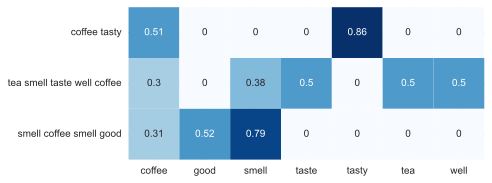

In [ ]:
sns.heatmap(df, square=True, cmap='Blues', annot=True, cbar=False);

## Topic Modeling

### Matrix Decomposition

The document term matrix $X$ is a matrix just like any other in Linear Algebra. Just so, it defines a row space (the documents represented as linear combinations of terms), and column space (terms represented as a linear combination of documents). With this, there are a few matrix decomposition methods we can use to extract further information about these documents and terms.

In [ ]:
from sklearn.decomposition import TruncatedSVD, NMF, PCA

### Singular Value Decomposition

Singular Value Decomposition is a guaranteed decomposition for any rectangular matrix. It creates the following equality:

$$
X = U\Sigma V^\top
$$

**Breifly**:
- Each row of $U$ represents the corresponding document in terms of "topics directions" along the columns.
- The rows of $V$ (columns of $V^\top$) represent similarly represented version of the terms.
- The $\Sigma$ matrix contains the "variance explained" by each of these topics, sorted in descending order.

As far as naming goes:

- The analysis of these resulting matrices is called **Principal Components Analysis (PCA)**.
- When used with text data, this analysis is called **Latent Semantic Analysis (LSA)**.

In [ ]:
# we need a list/array of strings to vectorize
corpus = df_coffee['spacy_doc'].apply(tokenizer, args={'join_tokens':True})

In [ ]:
corpus.shape

(2092,)

In [ ]:
cv = TfidfVectorizer(max_df=0.9,
                     min_df=0.1,
                     max_features=None)

X = cv.fit_transform(corpus)
# df = pd.DataFrame(X, index=corpus, columns=cv.get_feature_names_out())

In [ ]:
X.shape

(2092, 66)

Note, we use `TruncatedSVD` here because it's a more efficient implementation of SVD. PCA centers the data before running the algorithm, which is more "appropriate" but takes more time. This does cause a few inconsistencies in the "sorted" $\Sigma$.

In [ ]:
lsa = TruncatedSVD(n_components=5)  # results only change for larger (unseen) values

doc_topic = lsa.fit_transform(X)
lsa.explained_variance_ratio_

array([0.00476077, 0.08101226, 0.04735593, 0.04614582, 0.03468203])

In [ ]:
doc_topic = pd.DataFrame(doc_topic.round(3),
                         index=df_coffee['desc_1'])
# doc_topic.head()

In [ ]:
topic = 1
n_docs = 5

print(f"Top Documents for topic {topic}:\n")

for doc in doc_topic[topic].abs().sort_values(ascending=False).iloc[:n_docs].index:
    print(doc, '\n')

Top Documents for topic 1:

Sweetly floral and delicately cocoa-toned. Honeysuckle, cocoa nib, Concord grape, agave, lemon-thyme in aroma and cup. High-toned structure with juicy, confident acidity; buoyant, lively, viscous mouthfeel. Honeysuckle and cocoa nib characterize the sweet finish. 

Evaluated as espresso. Roast-rounded, chocolaty. Dark chocolate, gardenia, gently scorched cedar, molasses, prune in aroma and small cup. Viscous, creamy mouthfeel; chocolaty, slightly smoky finish. In three parts milk, floral and chocolate notes preside.  

Evaluated as espresso. Fruit-forward, chocolaty. Dark chocolate, black cherry, lily, molasses, cedar in aroma and small cup. Very syrupy mouthfeel; crisp, chocolaty finish. In three parts milk, dark chocolate notes take center stage, supported by notes of black cherry and lily. 

Evaluated as espresso. Bittersweet, richly pungent, chocolaty and floral. Dark chocolate, plum, cedar, magnolia in aroma and small cup. Plump, satiny mouthfeel; bitte

In [ ]:
topic_term = pd.DataFrame(lsa.components_.round(3),
                          columns = cv.get_feature_names_out())

topic_term

,acidity,almond,bake,balanced,bright,brisk,butter,cedar,center,chocolate,...,sweetly,syrup,syrupy,tart,tone,toned,undertone,velvety,vibrant,zest
0,0.193,0.125,0.091,0.103,0.118,0.072,0.069,0.168,0.082,0.259,...,0.148,0.079,0.145,0.197,0.215,0.118,0.078,0.070,0.066,0.110
1,0.074,-0.024,-0.140,0.065,0.120,-0.018,-0.017,-0.107,-0.003,-0.460,...,0.029,0.041,0.039,0.113,0.020,0.015,-0.016,-0.045,0.070,0.039
2,0.045,0.062,0.307,-0.037,-0.125,0.201,0.056,0.137,-0.007,-0.070,...,-0.059,0.061,-0.145,-0.113,0.068,0.088,0.059,0.124,-0.087,0.057
3,0.119,-0.013,0.095,0.010,-0.002,0.073,-0.035,-0.076,0.014,0.035,...,0.041,0.043,0.050,-0.028,-0.077,-0.025,-0.010,0.007,0.023,-0.002
4,-0.087,-0.167,-0.131,0.009,-0.167,-0.033,-0.085,-0.074,-0.064,-0.080,...,-0.140,-0.063,0.039,-0.374,-0.026,-0.061,0.024,0.020,-0.051,-0.010


In [ ]:
# the third "topic"
topic = 2
n_terms = 10

topic_term.T[topic].abs().sort_values(ascending=False).iloc[:n_terms]

bake          0.307
sandalwood    0.265
dark          0.257
nut           0.231
flavor        0.209
cut           0.206
juicy         0.206
brisk         0.201
hazelnut      0.197
fresh         0.196
Name: 2, dtype: float64

### Non-Negative Matrix Factorization

[NMF](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) is very similar to SVD. Here, we have the following decomposition for any non-negative matrix $X$ (i.e., its values $x_{ij} \geq 0$) with $n$ columns.

$$
X = WH
$$

... where $W$ has $k \leq n$ columns and $H$ has $k$ rows. In this case, all values in $W$ and $H$ are non-negative, and we use Scikit Learn to **approximate** this decomposition.

In [ ]:
# # example of approximation

# a = [[1, 2, 3, 4],
#      [5, 6, 7, 8]]

# k = 2
# nmf = NMF(k)

# w = nmf.fit_transform(a)
# h = nmf.components_

# w @ h

The first matrix, $W$, contains interesting information about how each row of $X$ could be represented using $k$ "topic" axes.

In [ ]:
nmf = NMF(4)  # here, the number will change the results
doc_topic = nmf.fit_transform(X)

In [ ]:
doc_topic = pd.DataFrame(doc_topic.round(3),
                         index=df_coffee['desc_1'])
# doc_topic.head()

In [ ]:
topic = 0
n_docs = 5

print(f"Top Documents for topic {topic}:\n")

for doc in doc_topic[topic].abs().sort_values(ascending=False).iloc[:n_docs].index:
    print(doc, '\n')

Top Documents for topic 0:

Nuanced, layered, richly sweet-savory. Fine musk, wisteria-like flowers, dark chocolate, pipe tobacco, black cherry in aroma and cup. Balanced sweet-tart-savory structure with juicy, vibrant acidity; plush, syrupy mouthfeel. The finish is resonant, flavor-saturated, and impressively long. 

Richly sweet, delicately savory. Lilac, chocolate fudge, pomegranate, frankincense, honey in aroma and cup. Balanced, sweetly savory structure with bright, juicy acidity; buoyant, syrupy mouthfeel. The flavor-saturated finish is resonant with notes of lilac and pomegranate in the short and chocolate-toned frankincense in the long. 

Richly savory-sweet, balanced, layered and lively. Red currant, maple syrup, honeysuckle, sandalwood, dark chocolate in aroma and cup. Deeply sweet-savory structure with juicy, confident acidity; full, syrupy mouthfeel. Long, flavor-saturated finish centers around red fruit and sweet-spicy floral notes. 

High-toned, richly savory-sweet. Red c

In [ ]:
topic_term = pd.DataFrame(nmf.components_.round(3),
                          columns = cv.get_feature_names_out())

topic_term

,acidity,almond,bake,balanced,bright,brisk,butter,cedar,center,chocolate,...,sweetly,syrup,syrupy,tart,tone,toned,undertone,velvety,vibrant,zest
0,0.954,0.410,0.00,0.587,0.870,0.000,0.097,0.044,0.360,0.828,...,0.915,0.243,1.229,1.013,0.627,0.225,0.093,0.000,0.564,0.349
1,0.000,0.173,0.00,0.043,0.000,0.000,0.132,0.605,0.112,1.574,...,0.142,0.000,0.172,0.186,0.382,0.080,0.177,0.121,0.000,0.059
2,0.542,0.480,0.96,0.115,0.000,0.609,0.295,0.649,0.208,0.698,...,0.229,0.292,0.033,0.190,0.532,0.481,0.277,0.431,0.000,0.345
3,0.491,0.160,0.00,0.362,0.489,0.019,0.115,0.283,0.165,0.000,...,0.334,0.228,0.311,0.710,0.619,0.294,0.195,0.050,0.256,0.309


In [ ]:
topic = 0
n_terms = 10

topic_term.T[topic].sort_values(ascending=False).iloc[:n_terms]

savory        2.358
sweet         1.434
long          1.291
syrupy        1.229
flavor        1.226
juicy         1.142
sandalwood    1.133
structure     1.120
resonant      1.055
richly        1.036
Name: 0, dtype: float64

In [ ]:
topic = 1
n_terms = 10

topic_term.T[topic].sort_values(ascending=False).iloc[:n_terms]

chocolate    1.574
dark         1.296
milk         1.125
espresso     1.120
evaluate     1.093
small        1.092
chocolaty    1.015
cedar        0.605
fruit        0.520
floral       0.485
Name: 1, dtype: float64

As you can tell, this often produces more agreeable results than LSA.

### Latent Dirichlet Allocation (LDA)

[LDA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) is a "generative" model that builds topics with the assumption that documents are generated based on a probability distribution of topics, and that topics are just a probability distribution of terms.

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
# these parameters usually require a good bit of tuning ...
lda = LatentDirichletAllocation(n_components=5,
                                max_iter=50)

X_topics = lda.fit_transform(X)

In [ ]:
df_lda = pd.DataFrame(data = X_topics,
                      index = corpus)

In [ ]:
topic = 0
n_docs = 3

for d in df_lda[topic].sort_values(ascending=False).iloc[:n_docs].index:
    print(d, '\n')

crisp sweetly nut tone hazelnut butter baker chocolate cherry cedar freesia like flower aroma cup sweet toned structure brisk acidity velvety smooth mouthfeel sweet finish consolidate invite nutty chocolate short spice tone floral long 

deeply sweet richly nut tone hazelnut butter magnolia like flower crisp pear cedar agave syrup aroma cup sweet structure gentle round acidity syrupy smooth mouthfeel finish consolidate deep nut rich aromatic wood 

high tone crisply sweet maple syrup orange z honeysuckle like flower cedar almond butter aroma cup sweetly roundly tart structure satiny mouthfeel richly dry finish redolent honeysuckle orange z short round buttery nut suggestion long 



In [ ]:
topic = 1
n_docs = 3

for d in df_lda[topic].sort_values(ascending=False).iloc[:n_docs].index:
    print(d, '\n')

rich tone deeply sweetly earthy chocolate fudge white sage blackberry perique pipe tobacco plumeria like flower aroma cup balanced sweet savory structure vibrant juicy acidity delicate satiny mouthfeel resonant flavor saturate finish display note blackberry tobacco short plumeria sage long deep chocolate 

richly sweet chocolaty fruit tone mango dark chocolate sandalwood maple syrup rhododendron like flower aroma cup sweet toned structure bright juicy acidity plush syrupy mouthfeel resonant flavor saturate finish lead mango dark chocolate suggestion 

high tone sweetly tart deeply savory jasmine dark chocolate lemon verbena pink grapefruit zest candycap mushroom aroma cup balanced sweet tart savory structure lyrical syrupy smooth mouthfeel flavor saturate finish lead citrus note lemon verbena grapefruit short round deep chocolate sweet mushroom long 



In [ ]:
df_lda_terms = pd.DataFrame(data = lda.components_,
                            columns = cv.get_feature_names_out())

In [ ]:
topic = 0
n_terms = 10

df_lda_terms.T[topic].sort_values(ascending=False).iloc[:n_terms]

bake         91.170267
sweet        69.536419
chocolate    68.109455
nut          62.338152
hazelnut     60.872625
cedar        53.503223
tone         49.110128
acidity      48.668174
structure    47.008898
gentle       45.466174
Name: 0, dtype: float64

In [ ]:
topic = 1
n_terms = 10

df_lda_terms.T[topic].sort_values(ascending=False).iloc[:n_terms]

chocolate    131.701500
dark         121.019828
savory       104.736237
sweet         89.032038
structure     69.194550
acidity       59.570781
richly        57.855110
tone          56.111192
tart          55.424604
syrupy        54.873703
Name: 1, dtype: float64

### Anchored Correlation Explanation (CorEx)

[CorEx](https://github.com/gregversteeg/corex_topic) is a discriminative model, which starts from $X$ (documents/words) to determine $Y$ (topics). CorEx looks for groups of words that are in the same topic, a.k.a. have high Total Correlation (TC), or convey the same information.

- If words are **tightly related** (always appear together in the same topic/document), TC will be high. This is a good topic.
- If the words are all **independent** (never appear together in the same document or topic), TC = 0. This is a bad topic.
- CorEx creates a partition across terms. I.e., **terms can only occur in a single topic**.

CorEx roughly follows this algorithm:
1. Look for a group of words that are both as broad (in many documents) and overlapping as possible (both together will lead to high TC), and call this a topic.
2. Repeat the process for another set of words (not overlapping with your previous group) with as high a TC as possible, and call this the next topic.

As we create more topics, each subsequent topic will have lower TC.

In [ ]:
from corextopic import corextopic as ct

In [ ]:
# CorEx requires count data
cv = CountVectorizer(max_df=0.9,
                     min_df=0.1,
                     max_features=None)

X = cv.fit_transform(corpus)

In [ ]:
topic_model = ct.Corex(n_hidden=5,                        # number of topics
                       words=cv.get_feature_names_out(),  # list of terms in corpus
                       seed=1)

doc_topic = topic_model.fit_transform(X, words=cv.get_feature_names_out(), docs=corpus)

In [ ]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()

for n, topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print(f"{n}: " + ','.join(topic_words))

0: espresso,evaluate,small,milk,structure,acidity,sweet,consolidate,floral,syrup
1: chocolate,dark,nib,cocoa,bake,delicate,lemon,deep
2: juicy,cut,fresh,gentle,tart,bright,brisk,high,sandalwood,vibrant
3: long,short,flavor,resonant,undertone,nut,lead,syrupy,savory,gently
4: chocolaty,cedar,balanced,zest,center


Take a look at how you can use [anchor words](https://github.com/gregversteeg/corex_topic/tree/master#using-anchor-words) to guide the topic creation.

## Sentiment Analysis with VADER

According to [the documentation](https://github.com/cjhutto/vaderSentiment):

    VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. [...]
    
    Sentiment ratings from 10 independent human raters (all pre-screened, trained, and quality checked for optimal inter-rater reliability). Over 9,000 token features were rated on a scale from "[–4] Extremely Negative" to "[4] Extremely Positive", with allowance for "[0] Neutral (or Neither, N/A)".

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
sentences = [
    "VADER is smart, handsome, and funny.",  # positive sentence example
    "VADER is smart, handsome, and funny!",  # punctuation emphasis handled correctly (sentiment intensity adjusted)
    "VADER is very smart, handsome, and funny.", # booster words handled correctly (sentiment intensity adjusted)
    "VADER is VERY SMART, handsome, and FUNNY.",  # emphasis for ALLCAPS handled
    "VADER is VERY SMART, handsome, and FUNNY!!!", # combination of signals - VADER appropriately adjusts intensity
    "VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!", # booster words & punctuation make this close to ceiling for score
    "VADER is not smart, handsome, nor funny.",  # negation sentence example
    "The book was good.",  # positive sentence
    "At least it isn't a horrible book.",  # negated negative sentence with contraction
    "The book was only kind of good.", # qualified positive sentence is handled correctly (intensity adjusted)
    "The plot was good, but the characters are uncompelling and the dialog is not great.", # mixed negation sentence
    "Today SUX!",  # negative slang with capitalization emphasis
    "Today only kinda sux! But I'll get by, lol", # mixed sentiment example with slang and constrastive conjunction "but"
    "Make sure you :) or :D today!",  # emoticons handled
    # "Catch utf-8 emoji such as such as 💘 and 💋 and 😁",  # emojis handled, ignored for seaborn plot below
    "Not bad at all"  # Capitalized negation
]

In [ ]:
df_sentiment = []

analyzer = SentimentIntensityAnalyzer()

for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    df_sentiment.append(vs)

In [ ]:
df_sentiment = pd.DataFrame(df_sentiment,
                            index = sentences)

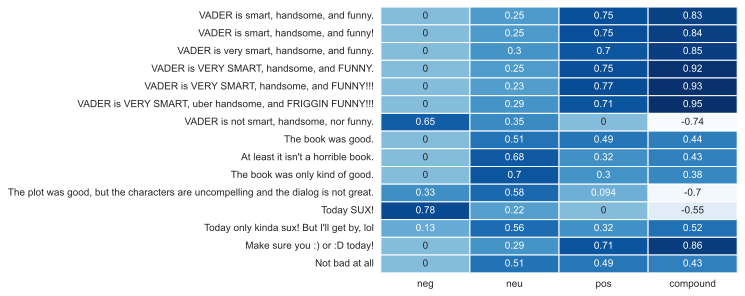

In [ ]:
sns.heatmap(df_sentiment, cmap='Blues', annot=True, cbar=False, linewidths=1);

## Other Tools

NLP is a vast field all on its own, so of course there are *countless* NLP tools and techniques out there, and we can't begin to cover them all. That said, the ones addressed above are nice because the are commonly used, easy to implement, and lightweight, without the need for obstruse models or lots of computational power.

On the other hand, there are a few other more advanced models that are worth mentioning:

### ScatterText

[Scattertext](https://github.com/JasonKessler/scattertext?tab=readme-ov-file#overview) is a powerful tool for visualizing how terms in a corpus vary across a binary spectrum. For example, you could study how terms behave accross reviews from negative to positive, or how terms vary across political speeches from left (liberal) to right (conservative). If you have an underlying binary label across your documents, Scattertext can be a useful exploratory data analysis tool.

That said, Scattertext requires an older version of NumPy, and this creates an incompatibility for most environments. So, **Scattertext requires a separate environment altogether**. Further, it can be a bit tricky to configure, and the results are usually not immediately actionable. For this reason, we do not include a demonstration of Scattertext here, but you are more than welcome to investigate it at the link above.

---

### Pre-Trained Language Models

*The following tools use pre-trained language models. <font color='darkorange'>To properly use these tools, it helps to have knowledge that is outside of scope of this course.</font> You are welcome to explore these tools, but I encourage you to wait until you are comfortable with the mechanics of neural networks, embeddings, transformers, and large language models (LLMs).*

- **[LangExtract](https://github.com/google/langextract)** uses user-defined contextual parameters to extract specific information from text. It also has a nice visualization interface to visualize results. For example, you could use what you know about one portion of text to extrapolate information from another portion of text.
- **[Hugging Face](https://huggingface.co/)** is the industry-standard platform for pre-trained language models. It has a user-friendly interface and a large community of users.
    - [Transformers](https://huggingface.co/docs/transformers/index) makes it relatively to apply pre-trained models in your own projects.
    - [SBERT](https://sbert.net/docs/quickstart.html) provides a framework for analyzing sentences using their embeddings.
- **[spaCy Transformers](https://spacy.io/universe/project/spacy-transformers)** is an extension of spaCy that uses Hugging Face models to create document embeddings, etc.
- **[BERTopic](https://maartengr.github.io/BERTopic/index.html)** is a nice topic modeling tool that uses transformer models to create document embeddings, and then applies clustering algorithms to create topics.

---

# Explore

Test your understanding of this week's content with the following explorations.

*Note: unless otherwise noted, **explorations are completely optional and will not be reviewed.***

## Exploration 1

...

## Exercise 1

Using a book from [Project Gutenberg](https://www.gutenberg.org/), get the text data directly from its URL using the `requests` package. Break the book into 50 or more sensible "chunks" like chapters or paragraphs, organizing them into a list.

Load this data into a spaCy pipeline and analyze either Named Entities or Parts of Speech in each chunk.

Provide your analysis: What types of entities or parts of speech are common, and what are uncommon? What insights can you draw from these patterns?

*Note*: Do not download any file, make use of URL in your code.

In [ ]:
# write your code here ...

## Exercise 2

Apply spaCy to extract the most meaningful content from your documents, considering options like excluding stop words or focusing on nouns (i.e. preprocessing and filtering).

Perform a sentiment analysis on the refined data. Create visualization of your result.

Summarize your results by explaining how sentiment changes across sections.

In [ ]:
# write your code here ...